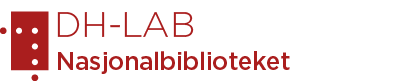

Her vil jeg etablere et Skramkorpus og gjøre ting med det. Jeg vil i første omgang lage korpus og deretter hente ut stedsnavn. Til dette prøver jeg å kombinere Notebooks for korpusbygging og "Navnegrafer". 

In [1]:
import dhlab.nbtext as nb
from dhlab.module_update import css
%matplotlib inline
css()

In [2]:
from dhlab.module_update import update, css
import dhlab.nbtext as nb
from dhlab.nbtext import get_urn, make_graph, get_urn, relaterte_ord, navn, totals
import dhlab.graph_networkx_louvain as gnl
import dhlab.token_map as tm
%matplotlib inline

plot = lambda x,  lw=3, alpha= 0.7: x.plot(figsize=(15,6), lw=lw, alpha=alpha)

In [19]:
import re

In [3]:
import warnings
warnings.filterwarnings('ignore')

css()

# Hjelpekommandoer

`alle_korpusnavn` henter ut alle navn (eller forslag til) fra korpuset.
`tell_navn` teller opp navnene på tvers av korpuset 


In [4]:
import pandas as pd

def alle_korpusnavn(korpus, ratio=0.3, cutoff=0):
    urner = nb.pure_urn(korpus)
    alle_navn = tm.combine_names(tm.corpus_names(urner, ratio = ratio, cutoff = cutoff))
    return alle_navn

def tell_navn(korpus, token_map):
    res = dict()
    for urn in korpus['urn']:
        res[urn] = tm.count_name_strings(str(urn), token_map).to_dict()[0]
    return pd.DataFrame(pd.DataFrame(res).sum(axis=1).sort_values(ascending=False))

## Navn i bøker


Vi søker etter navn i en bok, og en serie av bøker.

Kommandoene er:
1. `names` henter et sett med forslag til navn, fra nbtext
1. `show_names` gir en oversikt over funnene, fra token_map
1. `names_to_token_map_file` lagrer navneforslagene til en excelfil (eller csv) for redigering (token_map)
1. `read_token_map_file` henter redigert fil tilbake for analyse (token_map)
1. `character_network` lager graf for navnene (token_map)
1. `show_graph`  tegner grafen (fra graph_networkx_louvain)
1. `show_communities` viser clustre i grafen (graph_networkx_louvain)


In [5]:
korpus = nb.restore_metadata_from_excel('skram_korpus_sv.xls')

In [6]:
korpus

,urn,forfatter,år,tittel,subtittel,forlag,x,x.1,lang,trans
0,2008012904020,"Skram, Amalie",1993,Samlede verker 1,NaN,NaN,NaN,NaN,NaN,NaN
1,2008011000051,"Skram, Amalie",1993,Samlede verker 2,NaN,NaN,NaN,NaN,NaN,NaN
2,2008010900076,"Skram, Amalie",1993,Samlede verker 3,NaN,NaN,NaN,NaN,NaN,NaN
3,2008012801071,"Skram, Amalie",1993,Samlede verker 4,NaN,NaN,NaN,NaN,NaN,NaN
4,2008012801072,"Skram, Amalie",1993,Samlede verker 5,NaN,NaN,NaN,NaN,NaN,NaN
5,2008012804059,"Skram, Amalie",1993,Samlede verker 6,NaN,NaN,NaN,NaN,NaN,NaN
6,2008012804063,"Skram, Amalie",1993,Samlede verker 7,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
nb.pure_urn(korpus)

['2008012904020',
 '2008011000051',
 '2008010900076',
 '2008012801071',
 '2008012801072',
 '2008012804059',
 '2008012804063']

In [8]:
nb.urn_concordance(word = 'damperen', urns = nb.pure_urn(korpus))

"Samlede verker, Skram, Amalie, 1993","hvitgrønne boblende skumstripe , som",damperen,slepte efter sig i det
"Samlede verker, Skram, Amalie, 1993",» master . Akterut fra,damperen,skrek en mann noen hese
"Samlede verker, Skram, Amalie, 1993","tilbake som ekko , svingte",damperen,"rundt i en halvcirkel, og"
"Samlede verker, Skram, Amalie, 1993",Om et kvarters tid vilde,damperen,"legge til ved Bratøen ,"
"Samlede verker, Skram, Amalie, 1993",bryggen og speide ut mot,damperen,. Det var over deres
"Samlede verker, Skram, Amalie, 1993",Et par minutter efter la,damperen,til ved bryggen ; en
"Samlede verker, Skram, Amalie, 1993","ut over sjøen , hvor",damperen,kom glidende . Om et
"Samlede verker, Skram, Amalie, 1993",Han gikk ombord på,damperen,", som straks efter gled"
"Samlede verker, Skram, Amalie, 1993",Så la da,damperen,til ved Nordfjordeidet . Bredt
"Samlede verker, Skram, Amalie, 1993",i mengde la til omkring,damperen,.


## Navn

Finn forslag til navn med `names`. Se på dem med `show_names`. Her er det muligheter til å skru litt på parametrene. Hvis ratioen skrus ned fjernes en del ord, og om cutoff settes høyere vil også enkelte navneforslag kunne forsvinne.

Velg hvilken bok som skal studeres (alle kan tas, men se under). Se på listen over korpus og sett den indeksen som passer. Her er det bare å føle seg frem.

nb.names har cutoff 2 som default - cutoff 1 fjerner litt mindre 

I funksjonen alle_korpusnavn er cutoff satt til null. 

**Cutoff virker pr. bok, så i et korpus kan jo et navn forekomme 1 gang pr. bok, og likevel ha en høy frekvens.**

Legger i ratio og cutoff eksplisitt her, så det er helt klart.

In [9]:
names_total = alle_korpusnavn(list(korpus.urn), ratio=0.3, cutoff = 0)

Tar ut bare single navn - for enkelhets skyld her, og ser mer på dem, som aktuelle stedsnavn

In [10]:
singles = names_total[0]

In [11]:
navn_tot = nb.frame(singles)

In [12]:
navn_tot.loc[[y for y in "Sandviken, Kingston, Jamaica, Bergen, Hellemyren, Dreggen, Skuteviken, Kristiania".split(', ') if y in navn_tot.index]]

,0
Sandviken,10
Kingston,5
Jamaica,2
Bergen,52
Hellemyren,9
Dreggen,4
Skuteviken,6
Kristiania,71


### Lagring og redigering

Rediger filen fra cellen med lagringskommando (`names_to_token_map_file(....)`)
Listen trenger litt redigering, og sammenslåing. Lagre til Excel, og benytt `orient = column` for å ha navn i kolonnner, eller `orient = row` for å redigere radvis. Noen store filer med over 256 navn krever `row`. Kommandoen sjekker om filen allerede fins, og vil ikke skrive over. Følg med på output.

In [13]:
tm.names_to_token_map_file(names_total, filename = "NER_skram_korpus_sv_vinterferie2.xls", orient = "row")

True

# Hent geonavn for Norge fra NO-mappen

In [14]:
geonavn = pd.read_csv("../NO/NO.txt", delimiter="\t", header=None)

Felt 3 har forskjellige varianter, så vi kan søke der for stedsnavn. Sikrer at Kristiania blir med.

In [15]:
geonavn.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,470883,Jakobselvvatnet,Jakobselvvatnet,"Jakobselvvand,Jakobselvvann,Jakobselvvatn,Jako...",69.55117,30.91213,H,LK,NO,NaN,0.0,NaN,NaN,NaN,0,NaN,118,Europe/Oslo,2019-10-09
1,471405,Vaggatem,Vaggatem,"Ozero Bukhtles-Vandet,Ozero Vouvatusyarvi,Ozer...",69.27159,29.26756,H,LK,NO,NaN,54.0,5444.0,NaN,NaN,0,NaN,52,Europe/Oslo,2019-12-12
2,471746,Jakobselva,Jakobselva,"Jakobselv,Jakobselva,Vor'yema,Vor’yema,Vuoremi...",69.77440,30.83950,H,STM,NO,RU,0.0,NaN,NaN,NaN,0,NaN,20,Europe/Oslo,2019-09-29
3,477327,Porog Vakker-Striket,Porog Vakker-Striket,"Gaddoluobalguoikka,Porog Vakker-Striket,Vaggat...",69.30070,29.31574,H,RPDS,NO,RU,0.0,NaN,NaN,NaN,0,NaN,52,Europe/Oslo,2017-08-01
4,484575,Tangenfossen,Tangenfossen,"Bornjeguoikka,Buornesava,Porog Tange-Foss,Purn...",69.07358,29.17126,H,FLLS,NO,NaN,54.0,5444.0,NaN,NaN,0,NaN,84,Europe/Oslo,2019-12-12


# Sjekk mot Skram-korpuset

Henter ut alle felt det er navn på i databasen for Norge. Bruker et regulært uttrykk, siden stedsnavnene står mellom , eller i start eller slutt.

In [16]:
geonames = geonavn.fillna('')

In [23]:
skram_geo = pd.DataFrame()
for n in navn_tot.index:
    
    try:
        
        # må bruke re.escape(n) for å sikre at ikke uttrykket tolkes som en regex
        pattern = '(^|,)' + re.escape(n) +'(,|$| )'
        skram_geo = skram_geo.append(geonames[geonames[3].str.contains(pattern)])
    
    except:
        
        print(n)

In [24]:
steder = list({x for x in skram_geo[1]})

In [25]:
skram_geo.to_csv('skram_samlede_stedsnavn.csv')